In [1]:
import pandas as pd
import numpy as np
import feather
import re
import folium
from shapely.geometry import MultiLineString
from shapely import geometry, ops
pd.options.display.max_columns = None

# Load and Clean the Data

## Ticket Data for 2020 and 2021

- Load preprocessed files from feather

In [2]:
ticket20 = feather.read_dataframe('ticket_2020.feather')
# ticket19 = feather.read_dataframe('ticket_2019.feather')

### Peek at the Data

In [3]:
ticket20.sample(5)

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
10094605,5109878924,EAW2492,NY,PAS,03/09/2020 12:00:00 AM,7,SUBN,LEXUS,V,0,0,0,0,NaN,0,0,0,None,None,1017P,None,QN,None,None,HORACE HARDING EXPWY,(E/B) @ 173RD ST,0,1111,D,T,None,None,None,WHGY,NaN,2017,None,0,None,FAILURE TO STOP AT RED LIGHT,NaN,NaN,NaN
11475838,4688524274,JJZ7833,NY,PAS,05/01/2020 12:00:00 AM,36,SUBN,FORD,V,0,0,0,0,NaN,0,0,0,None,None,0127P,None,BX,None,None,SB GRAND CONCOURSE @,MARCY PL,0,1180,B,T,None,None,None,TN,NaN,2007,None,0,None,PHTO SCHOOL ZN SPEED VIOLATION,NaN,NaN,NaN
3637067,8773917485,E96LGM,NJ,PAS,09/22/2019 12:00:00 AM,20,4DSD,LEXUS,T,18830,10110,10010,88880088,19.0,19,19,365352,T103,M,0735A,None,NY,F,327,E 93rd St,None,0,408,D,None,YYYYYYY,None,None,OTHER,NaN,0,None,0,B,None,NaN,NaN,NaN
5075578,8764162825,2685610,IN,PAS,10/28/2019 12:00:00 AM,14,DELV,FRUEH,T,21230,0,0,88880088,1.0,1,1,365796,T105,H,1242P,None,NY,I,S,Fulton St,50ft W/of Broadway,0,408,C,None,YYYYYYY,None,None,WHITE,NaN,0,None,0,067,None,NaN,NaN,NaN
1056767,5107548404,AZC2043,NY,PAS,07/24/2019 12:00:00 AM,7,SUBN,SUBAR,V,0,0,0,0,NaN,0,0,0,None,None,0244P,None,QN,None,None,HORACE HARDING EXPWY,(E/B) @ 173RD ST,0,1111,D,T,None,None,None,BL,NaN,2015,None,0,None,FAILURE TO STOP AT RED LIGHT,NaN,NaN,NaN


In [4]:
ticket20.shape

(12495734, 43)

In [5]:
# ticket19.sample(5)

In [6]:
# ticket19.shape

### Step 1 - Drop Missing/Blank Street Codes (for now)

Since we plan to use street codes to get a location of each ticket, we drop every ticket with no street code in Street Code1, Street Code2, Street Code3 (note: these represent ~30% of the 12mn rows - not an insignificant amount of data - potentially can group by Violation Location/Precinct perhaps?)

In [7]:
ticket20_clean=ticket20[(ticket20['Street Code1']!=0) | (ticket20['Street Code2']!=0) | (ticket20['Street Code3']!=0)].copy()

### Step 2 - Add Leading Zeros Back to Street Codes - ensure 5 digit

In [8]:
ticket20_clean['Street Code1'] = ticket20_clean['Street Code1'].apply('{0:0>5}'.format)
ticket20_clean['Street Code2'] = ticket20_clean['Street Code2'].apply('{0:0>5}'.format)
ticket20_clean['Street Code3'] = ticket20_clean['Street Code3'].apply('{0:0>5}'.format)

In [9]:
ticket20_clean.head()

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
0,1477633194,J58JKX,NJ,PAS,05/08/1972 12:00:00 AM,16,SDN,HONDA,P,08730,05130,05280,0,72.0,72,504,342924,T504,0000,0523P,None,K,F,270,43 ST,None,0,408,E2,None,YYYYYBB,0800A,0400P,BK,0.0,0,-,0,None,None,NaN,NaN,NaN
1,1449715424,KRE6058,PA,PAS,08/29/1977 12:00:00 AM,98,SUBN,ME/BE,P,86530,71800,73110,0,77.0,77,77,961115,0077,0000,0428P,None,K,F,1953,UNION ST,None,0,408,F1,None,BBBBBBB,ALL,ALL,BLK,0.0,0,-,0,None,None,NaN,NaN,NaN
2,1455779155,444326R,NJ,PAS,10/03/1988 12:00:00 AM,20,SDN,LEXUS,P,27030,41330,69230,0,88.0,88,730,535422,T730,0000,0625A,None,K,O,45,CLERMONT AVENUE,None,0,408,D,None,BBBBBBB,ALL,ALL,BLACK,0.0,0,-,0,None,None,NaN,NaN,NaN
3,1458800908,F728330,OH,PAS,01/03/1990 12:00:00 AM,21,SDN,CHEVR,P,33030,93630,58730,0,90.0,90,301,355074,T301,0000,1106A,None,K,F,218,DIVISION AVE,None,0,408,C,None,BYBBYBB,1100A,1230P,None,0.0,0,-,0,None,None,NaN,NaN,NaN
4,1466038676,FMY9090,NY,PAS,02/14/1990 12:00:00 AM,21,SUBN,JEEP,S,45130,23930,68130,20210915,90.0,90,0,668676,KNBO,0000,1253A,None,K,F,850,GRAND ST,None,0,408,D1,None,BYBBYBB,1200A,0300A,GREY,0.0,2015,-,0,None,None,NaN,NaN,NaN


In [10]:
ticket20_clean['Violation County'].unique()

array(['K', 'Q', 'BX', None, 'NY', 'R', 'BK', 'QN', 'MN', 'K   F', 'ST',
       'QUEEN', 'KINGS', 'QNS'], dtype=object)

### Step 3 - Map Violation County to Borough Code

Code Borough InTicket

- 1 Manhattan NY/MN
- 2 Bronx BX
- 3 Brooklyn K/BK/KINGS
- 4 Queens Q/QN/QUEEN/QNS
- 5 Staten Island R/ST
- 6 Nassau County
- 7 Westchester
- 8 New Jersey

Drop the 'K   F' - only one data point

In [11]:
# ticket20_clean[ticket20_clean['Violation County']=='K   F']
ticket20_clean.drop([94098],inplace=True)

In [12]:
ticket20_clean['Violation County'].unique()

array(['K', 'Q', 'BX', None, 'NY', 'R', 'BK', 'QN', 'MN', 'ST', 'QUEEN',
       'KINGS', 'QNS'], dtype=object)

In [13]:
boro_dict = {'NY':'1',
             'MN':'1',
             'BX':'2',
             'K':'3',
             'BK':'3',
             'KINGS':'3',
             'Q':'4',
             'QN':'4',
             'QUEEN':'4',
             'QNS':'4',
             'R':'5',
             'ST':'5',
             'None':'0'
            }

In [14]:
ticket20_clean['Boro Code'] = ticket20_clean['Violation County'].map(boro_dict)
ticket20_clean.head()

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation,Boro Code
0,1477633194,J58JKX,NJ,PAS,05/08/1972 12:00:00 AM,16,SDN,HONDA,P,08730,05130,05280,0,72.0,72,504,342924,T504,0000,0523P,None,K,F,270,43 ST,None,0,408,E2,None,YYYYYBB,0800A,0400P,BK,0.0,0,-,0,None,None,NaN,NaN,NaN,3
1,1449715424,KRE6058,PA,PAS,08/29/1977 12:00:00 AM,98,SUBN,ME/BE,P,86530,71800,73110,0,77.0,77,77,961115,0077,0000,0428P,None,K,F,1953,UNION ST,None,0,408,F1,None,BBBBBBB,ALL,ALL,BLK,0.0,0,-,0,None,None,NaN,NaN,NaN,3
2,1455779155,444326R,NJ,PAS,10/03/1988 12:00:00 AM,20,SDN,LEXUS,P,27030,41330,69230,0,88.0,88,730,535422,T730,0000,0625A,None,K,O,45,CLERMONT AVENUE,None,0,408,D,None,BBBBBBB,ALL,ALL,BLACK,0.0,0,-,0,None,None,NaN,NaN,NaN,3
3,1458800908,F728330,OH,PAS,01/03/1990 12:00:00 AM,21,SDN,CHEVR,P,33030,93630,58730,0,90.0,90,301,355074,T301,0000,1106A,None,K,F,218,DIVISION AVE,None,0,408,C,None,BYBBYBB,1100A,1230P,None,0.0,0,-,0,None,None,NaN,NaN,NaN,3
4,1466038676,FMY9090,NY,PAS,02/14/1990 12:00:00 AM,21,SUBN,JEEP,S,45130,23930,68130,20210915,90.0,90,0,668676,KNBO,0000,1253A,None,K,F,850,GRAND ST,None,0,408,D1,None,BYBBYBB,1200A,0300A,GREY,0.0,2015,-,0,None,None,NaN,NaN,NaN,3


### Step 4 - Create lookup String to get Street Names

In [15]:
ticket20_clean['Street1LU'] = 'PF'+ticket20_clean['Boro Code']+ticket20_clean['Street Code1']
ticket20_clean['Street2LU'] = 'PF'+ticket20_clean['Boro Code']+ticket20_clean['Street Code2']
ticket20_clean['Street3LU'] = 'PF'+ticket20_clean['Boro Code']+ticket20_clean['Street Code3']

In [16]:
ticket20_clean.head()

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation,Boro Code,Street1LU,Street2LU,Street3LU
0,1477633194,J58JKX,NJ,PAS,05/08/1972 12:00:00 AM,16,SDN,HONDA,P,08730,05130,05280,0,72.0,72,504,342924,T504,0000,0523P,None,K,F,270,43 ST,None,0,408,E2,None,YYYYYBB,0800A,0400P,BK,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF308730,PF305130,PF305280
1,1449715424,KRE6058,PA,PAS,08/29/1977 12:00:00 AM,98,SUBN,ME/BE,P,86530,71800,73110,0,77.0,77,77,961115,0077,0000,0428P,None,K,F,1953,UNION ST,None,0,408,F1,None,BBBBBBB,ALL,ALL,BLK,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF386530,PF371800,PF373110
2,1455779155,444326R,NJ,PAS,10/03/1988 12:00:00 AM,20,SDN,LEXUS,P,27030,41330,69230,0,88.0,88,730,535422,T730,0000,0625A,None,K,O,45,CLERMONT AVENUE,None,0,408,D,None,BBBBBBB,ALL,ALL,BLACK,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF327030,PF341330,PF369230
3,1458800908,F728330,OH,PAS,01/03/1990 12:00:00 AM,21,SDN,CHEVR,P,33030,93630,58730,0,90.0,90,301,355074,T301,0000,1106A,None,K,F,218,DIVISION AVE,None,0,408,C,None,BYBBYBB,1100A,1230P,None,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF333030,PF393630,PF358730
4,1466038676,FMY9090,NY,PAS,02/14/1990 12:00:00 AM,21,SUBN,JEEP,S,45130,23930,68130,20210915,90.0,90,0,668676,KNBO,0000,1253A,None,K,F,850,GRAND ST,None,0,408,D1,None,BYBBYBB,1200A,0300A,GREY,0.0,2015,-,0,None,None,NaN,NaN,NaN,3,PF345130,PF323930,PF368130


## Load Street Names DB and Create Lookup to StreetName Dict

In [17]:
stnames = pd.read_csv('/Users/stuartong/uberticketsyelp/Data/snd20d/snd20Dcow.txt')
stnames.columns=['Raw']

# from SND_metadata.pdf - location of stnames and Lookup prefixes
stnames['Street Name']=stnames['Raw'].str[2:34].str.strip()
stnames['Lookup']=stnames['Raw'].str[34:42]
stnames_dict= pd.Series(stnames['Street Name'].values,index=stnames['Lookup']).to_dict()

In [18]:
stnames

,Raw,Street Name,Lookup
0,11 0 BOND STREET PF1006890101...,0 BOND STREET,PF100689
1,11 1 AVENUE PF1100100101...,1 AVENUE,PF110010
2,11 1 AVENUE LOOP PF1317200102...,1 AVENUE LOOP,PF131720
3,11 1 AVENUE LOWER NB ROADBED VF1100100701...,1 AVENUE LOWER NB ROADBED,VF110010
4,11 1 AVENUE NORTHBOUND ROADBED VF1100100601...,1 AVENUE NORTHBOUND ROADBED,VF110010
...,...,...,...
106756,15ZENI PLACE VS5341050102...,ZENI PLACE,VS534105
106757,15ZEPHYR AVENUE PF5566960101...,ZEPHYR AVENUE,PF556696
106758,15ZEV PLACE PF5703670101...,ZEV PLACE,PF570367
106759,15ZOE STREET PF5567150101...,ZOE STREET,PF556715


In [19]:
stnames_dict

{'PF100689': '0 BOND STREET',
 'PF110010': '1 AVENUE',
 'PF131720': '1 AVENUE LOOP',
 'VF110010': 'VETERANS WAY',
 'PF101127': '1 AVENUE TUNNEL',
 'PF113655': '1 DRIVE',
 'VS112740': '1 PARK',
 'VS100058': 'PRECINCT    1 STATIONHOUSE',
 'PF110015': '1 PLACE',
 'PF100058': '1 PRECINCT STATIONHOUSE',
 'VS101232': 'FIRST ST GARDEN',
 '        ': 'TREMONT AVENUE WB ROADBED',
 'VS101346': 'ONE VANDERBILT',
 'VS111115': 'WSH',
 'PF110110': '2 AVENUE',
 'VF110110': 'YITZHAK RABIN WAY',
 'VS110780': 'SECOND AVENUE NB ENTRANCE HRD',
 'VF127310': 'WHITE PLAINS ROAD LINE',
 'VS132622': 'TWO BRIDGES URA SITE    7 HOUSE',
 'PF113470': '2 DRIVE',
 'PF110115': '2 PLACE',
 'VS120490': 'ROOSEVELT DRIVE SB ROADBED',
 'VF197710': '3 AVE BRDG PED AND BIKE PATH',
 'VS197510': 'WEST INTREPID MUSEUM PED OVPS',
 'VF197510': 'WEST 178-179 STREET PED OVERPASS',
 'PF110210': '3 AVENUE',
 'VS197850': 'THIRD AVENUE BRIDGE APPROACH',
 'VS197710': 'THIRD AVENUE BRIDGE BIKE PATH',
 'VS110785': 'THIRD AVENUE BRIDGE SB

### Step 5 - Get Street Names 

In [20]:
ticket20_clean['Street1'] = ticket20_clean['Street1LU'].map(stnames_dict)
ticket20_clean['Street2'] = ticket20_clean['Street2LU'].map(stnames_dict)
ticket20_clean['Street3'] = ticket20_clean['Street3LU'].map(stnames_dict)

In [21]:
ticket20_clean.head(10)

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation,Boro Code,Street1LU,Street2LU,Street3LU,Street1,Street2,Street3
0,1477633194,J58JKX,NJ,PAS,05/08/1972 12:00:00 AM,16,SDN,HONDA,P,08730,05130,05280,0,72.0,72,504,342924,T504,0000,0523P,None,K,F,270,43 ST,None,0,408,E2,None,YYYYYBB,0800A,0400P,BK,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF308730,PF305130,PF305280,43 STREET,2 AVENUE,3 AVENUE
1,1449715424,KRE6058,PA,PAS,08/29/1977 12:00:00 AM,98,SUBN,ME/BE,P,86530,71800,73110,0,77.0,77,77,961115,0077,0000,0428P,None,K,F,1953,UNION ST,None,0,408,F1,None,BBBBBBB,ALL,ALL,BLK,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF386530,PF371800,PF373110,UNION STREET,PORTAL STREET,RALPH AVENUE
2,1455779155,444326R,NJ,PAS,10/03/1988 12:00:00 AM,20,SDN,LEXUS,P,27030,41330,69230,0,88.0,88,730,535422,T730,0000,0625A,None,K,O,45,CLERMONT AVENUE,None,0,408,D,None,BBBBBBB,ALL,ALL,BLACK,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF327030,PF341330,PF369230,CLERMONT AVENUE,FLUSHING AVENUE,PARK AVENUE
3,1458800908,F728330,OH,PAS,01/03/1990 12:00:00 AM,21,SDN,CHEVR,P,33030,93630,58730,0,90.0,90,301,355074,T301,0000,1106A,None,K,F,218,DIVISION AVE,None,0,408,C,None,BYBBYBB,1100A,1230P,None,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF333030,PF393630,PF358730,DIVISION AVENUE,WILSON STREET,MARCY AVENUE
4,1466038676,FMY9090,NY,PAS,02/14/1990 12:00:00 AM,21,SUBN,JEEP,S,45130,23930,68130,20210915,90.0,90,0,668676,KNBO,0000,1253A,None,K,F,850,GRAND ST,None,0,408,D1,None,BYBBYBB,1200A,0300A,GREY,0.0,2015,-,0,None,None,NaN,NaN,NaN,3,PF345130,PF323930,PF368130,GRAND STREET,BUSHWICK AVENUE,OLIVE STREET
5,1440657920,KDG0693,PA,PAS,07/21/1990 12:00:00 AM,14,SUBN,HYUN,P,33440,62200,00000,20191231,100.0,100,100,963999,0100,0000,0525P,None,Q,None,None,B 99 ST,SHORE FRONT PKWY,0,408,C,None,BBBBBBB,ALL,ALL,GY,0.0,0,-,0,None,None,NaN,NaN,NaN,4,PF433440,PF462200,PF400000,BEACH 99 STREET,SHORE FRONT PARKWAY,NaN
7,1449130203,JJJ8186,NY,PAS,10/14/1990 12:00:00 AM,14,SUBN,BMW,P,10020,27480,27540,20210710,52.0,52,52,964971,0052,0000,0320A,None,BX,F,2734,BAINBRIDGE AVE,None,0,408,F2,None,BBBBBBB,ALL,ALL,BLK,0.0,2010,-,0,None,None,NaN,NaN,NaN,2,PF210020,PF227480,PF227540,BAINBRIDGE AVENUE,EAST 194 STREET,EAST 196 STREET
8,1451300189,DKD6024,NC,PAS,07/25/1991 12:00:00 AM,98,SDN,FORD,P,11280,54137,05430,20190930,68.0,68,68,945183,0068,0000,0843P,None,K,F,372,94 ST,None,0,408,C3,None,BBBBBBB,ALL,ALL,GREY,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF311280,PF354137,PF305430,94 STREET,LAFAYETTE WALK,4 AVENUE
9,1464768973,6542FR,99,PAS,01/01/2000 12:00:00 AM,40,SUBN,CMCKU,P,18070,25390,27790,0,17.0,17,405,930288,0405,0000,0739P,None,None,F,65,E 54 ST,None,0,408,C,None,BBBBBBB,ALL,ALL,RED,0.0,0,-,2,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1449651100,JKZ9192,NY,PAS,01/02/2000 12:00:00 AM,74,SDN,HONDA,P,73470,48330,56230,20211014,73.0,73,73,0,0073,0000,1020A,None,None,None,985,ROCKAWAY AVE,None,0,408,F1,None,BBBBBBB,ALL,ALL,GREY,0.0,2019,-,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Load Centerline Database

We load both the CSV and the Geojson

In [22]:
cl_df= pd.read_csv('/Users/stuartong/uberticketsyelp/Data/Centerline.csv')
cl_df.head()

,the_geom,L_LOW_HN,PHYSICALID,L_HIGH_HN,R_LOW_HN,R_HIGH_HN,L_ZIP,R_ZIP,L_BLKFC_ID,R_BLKFC_ID,ST_LABEL,STATUS,BIKE_LANE,BOROCODE,ST_WIDTH,CREATED,MODIFIED,TRAFDIR,RW_TYPE,FRM_LVL_CO,TO_LVL_CO,SNOW_PRI,PRE_MODIFI,PRE_DIRECT,PRE_TYPE,POST_TYPE,POST_DIREC,POST_MODIF,FULL_STREE,ST_NAME,BIKE_TRAFD,SHAPE_Leng
0,MULTILINESTRING ((-73.87861544017795 40.861915...,NaN,164809,NaN,NaN,NaN,10458.0,10458.0,0,0,MITSUBISHI WILD WETLAND TRL,2,NaN,2,0,08/19/2014 12:00:00 AM +0000,12/22/2015 12:00:00 AM +0000,NV,6,13,13,NaN,NaN,NaN,NaN,TRL,NaN,NaN,MITSUBISHI WILD WETLAND TRL,MITSUBISHI WILD WETLAND,NaN,1026.077523
1,MULTILINESTRING ((-73.7729030190404 40.7778042...,215-001,6110,215-027,215-000,215-026,11360.0,11360.0,112261166,112262650,28 AVE,2,NaN,4,35,11/29/2007 12:00:00 AM +0000,08/28/2020 12:00:00 AM +0000,TW,1,13,13,S,NaN,NaN,NaN,AVE,NaN,NaN,28 AVE,28,NaN,258.859740
2,MULTILINESTRING ((-73.90711253281893 40.905186...,5631,61140,5699,5602,5698,10471.0,10471.0,1522604870,1522601877,ARLINGTON AVE,2,NaN,2,42,11/29/2007 12:00:00 AM +0000,08/28/2020 12:00:00 AM +0000,TW,1,13,13,H,NaN,NaN,NaN,AVE,NaN,NaN,ARLINGTON AVE,ARLINGTON,NaN,454.932922
3,MULTILINESTRING ((-73.98181677514282 40.687329...,317,145494,399,316,360,11217.0,11217.0,1922603730,1922612977,SCHERMERHORN ST,2,2.0,3,50,11/29/2007 12:00:00 AM +0000,04/15/2019 12:00:00 AM +0000,TW,1,13,13,C,NaN,NaN,NaN,ST,NaN,NaN,SCHERMERHORN ST,SCHERMERHORN,TW,609.424375
4,MULTILINESTRING ((-73.8300230194527 40.7140059...,120-011,12438,120-011,0,0,11415.0,11415.0,92261717,92269521,QUEENS BLVD,2,NaN,4,40,11/29/2007 12:00:00 AM +0000,04/15/2019 12:00:00 AM +0000,TF,1,13,13,C,NaN,NaN,NaN,BLVD,NaN,NaN,QUEENS BLVD,QUEENS,NaN,47.399228


In [23]:
cl_gjson=pd.read_json('/Users/stuartong/uberticketsyelp/Data/NYC Street Centerline (CSCL).geojson')

In [24]:
cl_gjson.head()

,type,features
0,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ..."
1,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ..."
2,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ..."
3,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ..."
4,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ..."


Extract some features from the geojson for easy access

In [25]:
cl_gjson['street']=cl_gjson['features'].str['properties'].str['full_stree']
cl_gjson['borocode']=cl_gjson['features'].str['properties'].str['borocode']
cl_gjson['roadtype']=cl_gjson['features'].str['properties'].str['rw_type']
cl_gjson['coords']=cl_gjson['features'].str['geometry'].str['coordinates']

# note some address contain '-' we only want the portion before the dash
cl_gjson['l_lowadd']=cl_gjson['features'].str['properties'].str['l_low_hn'].str.split('-').str[0]
cl_gjson['l_highadd']=cl_gjson['features'].str['properties'].str['l_high_hn'].str.split('-').str[0]
cl_gjson['r_lowadd']=cl_gjson['features'].str['properties'].str['r_low_hn'].str.split('-').str[0]
cl_gjson['r_highadd']=cl_gjson['features'].str['properties'].str['r_high_hn'].str.split('-').str[0]

cl_gjson.head()

,type,features,street,borocode,roadtype,coords,l_lowadd,l_highadd,r_lowadd,r_highadd
0,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",MITSUBISHI WILD WETLAND TRL,2,6,"[[[-73.87861544017795, 40.86191530153914], [-7...",None,None,None,None
1,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",28 AVE,4,1,"[[[-73.7729030190404, 40.77780428098228], [-73...",215,215,215,215
2,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",ARLINGTON AVE,2,1,"[[[-73.90711253281893, 40.90518625079211], [-7...",5631,5699,5602,5698
3,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",SCHERMERHORN ST,3,1,"[[[-73.98181677514282, 40.687329801759894], [-...",317,399,316,360
4,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",QUEENS BLVD,4,1,"[[[-73.8300230194527, 40.71400599781069], [-73...",120,120,0,0


In [26]:
cl_gjson[(cl_gjson['street']=='UNION ST')&(cl_gjson['borocode']=='3')].shape

(42, 10)

Looking for 'UNION ST' in geojson shows 42 rows, which line to take? Since ticket details have a house number, maybe we can use that to narrow it down to a segment. First we have to get the combined low and high address for each segment for left/right side of the street

In [27]:
# note have issues with none types convert to np.nan 
# we do this as some sides of the street do not have an address - i.e. 0 - so that we can evaluate the min

cl_gjson['r_lowadd'].replace({'0':np.nan},inplace=True)
cl_gjson['l_lowadd'].replace({'0':np.nan},inplace=True)
cl_gjson['c_lowadd']= cl_gjson[['l_lowadd','r_lowadd']].min(axis=1,skipna=True)
cl_gjson['c_highadd']=cl_gjson[['l_highadd','r_highadd']].max(axis=1)


In [28]:
cl_gjson.head()

,type,features,street,borocode,roadtype,coords,l_lowadd,l_highadd,r_lowadd,r_highadd,c_lowadd,c_highadd
0,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",MITSUBISHI WILD WETLAND TRL,2,6,"[[[-73.87861544017795, 40.86191530153914], [-7...",NaN,None,NaN,None,NaN,NaN
1,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",28 AVE,4,1,"[[[-73.7729030190404, 40.77780428098228], [-73...",215.0,215,215.0,215,215.0,215.0
2,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",ARLINGTON AVE,2,1,"[[[-73.90711253281893, 40.90518625079211], [-7...",5631.0,5699,5602.0,5698,5602.0,5699.0
3,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",SCHERMERHORN ST,3,1,"[[[-73.98181677514282, 40.687329801759894], [-...",317.0,399,316.0,360,316.0,399.0
4,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",QUEENS BLVD,4,1,"[[[-73.8300230194527, 40.71400599781069], [-73...",120.0,120,NaN,0,120.0,120.0


Now let's test it on a ticket for 1953 Union Street

In [29]:
test_json=cl_gjson[(cl_gjson['street']=='UNION ST')&(cl_gjson['borocode']=='3')&(cl_gjson['c_lowadd']<=1953)&(cl_gjson['c_highadd']>=1953)]

test_json

,type,features,street,borocode,roadtype,coords,l_lowadd,l_highadd,r_lowadd,r_highadd,c_lowadd,c_highadd
75249,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",UNION ST,3,1,"[[[-73.92468755711648, 40.667467610947966], [-...",1925.0,1979,1894.0,1984,1894.0,1984.0


In [30]:
# coordinates are reversed, flip for plotting

row1=[test_json.iloc[0]['coords'][0][0][::-1],test_json.iloc[0]['coords'][0][1][::-1]]

In [31]:
row1

[[40.667467610947966, -73.92468755711648],
 [40.667365056426824, -73.92272714241247]]

Additional test on 850 Grand Street

In [33]:
test_json=cl_gjson[(cl_gjson['street']=='GRAND ST')&(cl_gjson['borocode']=='3')&(cl_gjson['c_lowadd']<=850)&(cl_gjson['c_highadd']>=850)]

test_json

,type,features,street,borocode,roadtype,coords,l_lowadd,l_highadd,r_lowadd,r_highadd,c_lowadd,c_highadd
86827,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",GRAND ST,3,1,"[[[-73.94068803134424, 40.711962047631616], [-...",819.0,889,820.0,894,819.0,894.0


In [34]:
# coordinates are reversed, flip for plotting

row2=[test_json.iloc[0]['coords'][0][0][::-1],test_json.iloc[0]['coords'][0][1][::-1]]
row2

[[40.711962047631616, -73.94068803134424],
 [40.71248925594444, -73.93846617709357]]

## Test Vis

In [36]:
m = folium.Map(location=[40.6, -74],tiles="Stamen Toner")

# for each in row1:  
#     m.add_child(folium.CircleMarker(location=each,
#     fill='true',
#     radius = 6,
#     popup= 'Hi',
#     fill_color='blue',
#     color = 'clear',
#     fill_opacity=1))

folium.PolyLine(row1, color="red", weight=5, opacity=1).add_to(m)
folium.PolyLine(row2, color="blue", weight=5, opacity=1).add_to(m)
m


Using address generally looks like a good solution where it is available - but there are situations where no address is provided and using the interactions might still be an alternative solution for these tickets

## To Do

- Fix the text match for looking up - shortforms (ST vs STREET) and some text can't be recognized ??? (e.g.'E 17 ST')
- Figure out how to deal with those with missing street codes (sub routine to look at add no plus st name in the case of miss st codes?)
- For those without add no to narrow it down, figure out intersection math - note MultiLineString for all the st with the same name and boro need some work - line plotted appears to overlap (does coord order matter for MultiLineString? - yes the order the coordinates are fed into MultiLineString matter, need to explore the geom - is it standardized?)


In [42]:
cl_gjson['pid']=cl_gjson['features'].str['properties'].str['physicalid'].astype(int)

cl_gjson.sort_values(by=['pid'],inplace=True)

In [ ]:
first_line = MultiLineString([row1])
first_line

In [ ]:
second_line = MultiLineString([row2])
second_line

In [ ]:
combined =MultiLineString([row1,row2])
combined

In [ ]:
cl_gjson[(cl_gjson['street'].str.contains('BROADWAY'))&(cl_gjson['borocode']=='1')]

In [ ]:
cl_gjson[(cl_gjson['street']=='BROADWAY')&(cl_gjson['borocode']=='1')&(cl_gjson['roadtype']=='1')]

In [ ]:
GRAND STREET	BUSHWICK AVENUE	OLIVE STREET

In [43]:
ave3 = []
for i in cl_gjson[(cl_gjson['street']=='GRAND ST')&(cl_gjson['borocode']=='3')&(cl_gjson['roadtype']=='1')]['coords']:
    print (i[0])
    ave3.append(i[0][0])
    
e17st = []
for i in cl_gjson[(cl_gjson['street']=='BUSHWICK AVE')&(cl_gjson['borocode']=='3')]['coords']:
    print (i[0])
    e17st.append(i[0][0])
    
e18st = []
for i in cl_gjson[(cl_gjson['street']=='OLIVE ST')&(cl_gjson['borocode']=='3')]['coords']:
    print (i[0])
    e18st.append(i[0][0])

[[-73.96665848169509, 40.71635918368772], [-73.96609959111777, 40.716206112640855]]
[[-73.96677983767256, 40.71642538837487], [-73.96665848169509, 40.71635918368772]]
[[-73.96609959111777, 40.716206112640855], [-73.96447229927665, 40.71573310595641]]
[[-73.96447229927665, 40.71573310595641], [-73.96277758654267, 40.715106634804386]]
[[-73.96277758654267, 40.715106634804386], [-73.96128719656062, 40.71450229696462]]
[[-73.96128719656062, 40.71450229696462], [-73.95979763206105, 40.713887133734545]]
[[-73.95979763206105, 40.713887133734545], [-73.95834207509, 40.71330630064778]]
[[-73.95834207509, 40.71330630064778], [-73.95680951657143, 40.712756388272865]]
[[-73.95680951657143, 40.712756388272865], [-73.955475961298, 40.71226542569624]]
[[-73.93317899912154, 40.71379901901624], [-73.9323301595279, 40.71400996318601]]
[[-73.93480281865519, 40.713372495593696], [-73.93317899912154, 40.71379901901624]]
[[-73.93724803605217, 40.71278274129178], [-73.93480281865519, 40.713372495593696]]
[[-

In [ ]:
ave3 = [x[::-1] for x in ave3[0]]
ave3

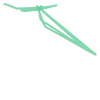

In [44]:
mls=MultiLineString([
   ave3,e17st,e18st
])

mls

In [45]:
line1=MultiLineString([ave3])
line2=MultiLineString([e17st])
line3=MultiLineString([e18st])
mylines = [line1,line2,line3]

In [ ]:
res1=line1.intersection(line2)
res1

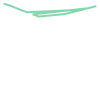

In [46]:
line1

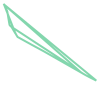

In [47]:
line2

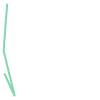

In [48]:
line3

In [ ]:
full_coords

In [ ]:
test_list

In [ ]:
cl_df[cl_df['ST_LABEL']=='84 ST']

In [ ]:


cl_gjson.loc[0]['features']

In [ ]:
import psycopg2

connection = psycopg2.connect(database='nyc_gis',user='stuart',password='stuart')
cursor = connection.cursor()
cursor.execute("CREATE TABLE street_data (id SERIAL PRIMARY KEY,stname VARCHAR(255),borocode INT, roadtype INT,shape GEOMETRY)")

In [ ]:
connection.commit()

In [ ]:
from shapely.geometry import MultiLineString
from shapely import geometry, ops

test=cl_gjson.loc[0]['features']['geometry']['coordinates']
test_list=[]
for i in test[0]:
    coord = (i[0],i[1])
    test_list.append(coord)
    
test_list

test2=cl_gjson.loc[2]['features']['geometry']['coordinates']
test_list2=[]
for i in test2[0]:
    coord = (i[0],i[1])
    test_list2.append(coord)
    
test_list2

In [ ]:


mls=MultiLineString([
   test_list,test_list2
])


In [ ]:
mls

In [ ]:
cl_gjson[cl_gjson['street']=='STERLING PL']

In [ ]:
from shapely.geometry import MultiLineString
from itertools import combinations

multiline=cl_gjson[cl_gjson['street']=='STERLING PL']['coords']
multiline

In [ ]:
for line1, line2 in combinations([line for line in multiline],2):
    if line1.intersects(line2):
        print(line1.intersection(line2))

In [ ]:
test=cl_df[(cl_df['FULL_STREE'].str.contains('63 ST')) & (cl_df['BOROCODE']==1) & (cl_df['RW_TYPE']==1)]['the_geom'].values.tolist()

In [ ]:
test

In [ ]:
cl_df[(cl_df['FULL_STREE'].str.contains('2 AVE')) & (cl_df['BOROCODE']==1) & (cl_df['RW_TYPE']==1)]['the_geom'].values.tolist()